In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.sparse as sps
import scipy as sp

import time
import line_profiler
%load_ext line_profiler

In [2]:
df = pd.read_csv('ml-latest\\ratings.csv')
df_movieId = pd.read_csv('ml-latest\\movies.csv')

df.head()

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264


In [19]:
# print some useful stats
df['rating'].value_counts()

4.0    7394710
3.0    5515668
5.0    4071135
3.5    3404360
4.5    2373550
2.0    1850627
2.5    1373419
1.0     886233
0.5     442388
1.5     441354
Name: rating, dtype: int64

In [4]:
# map half ratings to integer ratings by rounding up (e.g. .5 -> 1 and 3.5 -> 4)
# for jrating in [0.5,1.5,2.5,3.5,4.5]:
#     df[df['rating'] == jrating] = jrating+.5



# # map half ratings to integer ratings using a 50/50 split to nearest whole number
# df[df['rating'] == 0.5] = 1
# for jrating in [1.5,2.5,3.5,4.5]:
#     a = np.array(df[df['rating'] == jrating].index,dtype=int)
#     np.random.shuffle(a) # shuffle in-place, returns none
#     num_ratings = len(a)
#     df.loc[list(a[0:int(np.ceil(num_ratings/2))]),'rating'] = jrating-.5
#     df.loc[list(a[int(np.ceil(num_ratings/2)):]),'rating'] = jrating+.5

In [20]:
df['rating'].value_counts()

4.0    7394710
3.0    5515668
5.0    4071135
3.5    3404360
4.5    2373550
2.0    1850627
2.5    1373419
1.0     886233
0.5     442388
1.5     441354
Name: rating, dtype: int64

In [57]:
# drop certain percentage of users to make the dataset more manageable for testing
df.drop(df[df.userId > 1000].index, inplace=True)

In [58]:
df = df.drop(columns=['timestamp'])

KeyError: "['timestamp'] not found in axis"

In [59]:
# create new_ids that are run continously from [0, num_movies-1]
num_movies = len(np.unique(df['movieId']))
old_movie_id = np.unique(df['movieId'])
new_movie_id = np.array(range(0, num_movies), dtype=int)

# create new_ids that are run continously from [0,num_users-1]
num_users = len(np.unique(df['userId']))
old_user_id = np.unique(df['userId'])
new_user_id = np.array(range(0,num_users),dtype=int)

# create dictonary for mapping old_ids to new_ids
movie_map = {old_movie_id[j]:new_movie_id[j] for j in range(num_movies)}
user_map = {old_user_id[j]:new_user_id[j] for j in range(num_users)}

# perform the mapping
df['movieId'] = df['movieId'].map(movie_map)
df['userId'] = df['userId'].map(user_map) 

In [60]:
# 
data = np.array(df['rating'])
col = np.array(df['movieId'], dtype=int)
row = np.array(df['userId'], dtype=int)

Rs = sps.coo_array((data, (row, col)), shape=(len(new_user_id), len(new_movie_id)))
Rsc = sps.coo_array((data, (row, col)), shape=(len(new_user_id), len(new_movie_id))).tocsc()
Rsr = sps.coo_array((data, (row, col)), shape=(len(new_user_id), len(new_movie_id))).tocsr()


nnz_row_per_col = np.diff(Rsc.indptr)
nnz_col_per_row = np.diff(Rsr.indptr)

nonzero_rows = Rsc.nonzero()[0]
nonzero_cols = Rsc.nonzero()[1]

# find mean of each row and column
meanCol = Rsc.mean(axis=0)*num_users/nnz_row_per_col
meanRow = Rsc.mean(axis=1)*num_movies/nnz_col_per_row

# # find std of each row and column
# Rsc2 = Rsc**2
# stdCol = np.sqrt(Rsc2.mean(axis=0)*num_users/nnz_row_per_col - (Rsc.mean(axis=0)*num_users/nnz_row_per_col)**2)
# stdRow = np.sqrt(Rsc2.mean(axis=1)*num_movies/nnz_col_per_row - (Rsc.mean(axis=1)*num_movies/nnz_col_per_row)**2)

# compute alternate arrays
Rsc_mean = Rsc.copy()
Rsc_mean.data = Rsc_mean.data - np.take(meanRow, Rsc_mean.indices)

Rsr_mean = Rsc_mean.tocsr()



# compute set of observed indices (i, j) = (rows, cols)
irows, jcols, vals = sps.find(Rsc)
num_nonzero_entries = len(vals)

In [61]:
Rsc_mean.data

array([ 0.60258152,  0.80991736,  0.55172414, ..., -2.46875   ,
        0.03125   ,  0.        ])

In [62]:
nnz_col_per_row

array([ 16,  15,  11, ...,  18, 240,   5])

In [77]:
def in1ds(ar1, ar2, assume_unique=True, invert=False, *, kind='table'):

    if ar2.size == 0:
        return np.zeros_like(ar1, dtype=bool)

    ar2_min = ar2[0]#np.min(ar2)
    ar2_max = ar2[-1]#np.max(ar2)

    ar2_range = int(ar2_max) - int(ar2_min)

    # Constraints on whether we can actually use the table method:
    #  1. Assert memory usage is not too large
    # below_memory_constraint = ar2_range <= 6 * (ar1.size + ar2.size)
    #  2. Check overflows for (ar2 - ar2_min); dtype=ar2.dtype
    # range_safe_from_overflow = ar2_range <= np.iinfo(ar2.dtype).max
    #  3. Check overflows for (ar1 - ar2_min); dtype=ar1.dtype
    # if ar1.size > 0:
        # ar1_min = ar1[0]#np.min(ar1)
        # ar1_max = ar1[-1]#np.max(ar1)

        # # After masking, the range of ar1 is guaranteed to be
        # # within the range of ar2:
        # ar1_upper = min(int(ar1_max), int(ar2_max))
        # ar1_lower = max(int(ar1_min), int(ar2_min))

        # range_safe_from_overflow &= all((
        #     ar1_upper - int(ar2_min) <= np.iinfo(ar1.dtype).max,
        #     ar1_lower - int(ar2_min) >= np.iinfo(ar1.dtype).min
        # ))

    # Optimal performance is for approximately
    # log10(size) > (log10(range) - 2.27) / 0.927.
    # However, here we set the requirement that by default
    # the intermediate array can only be 6x
    # the combined memory allocation of the original
    # arrays. See discussion on 
    # https://github.com/numpy/numpy/pull/12065.

    # if (
    #     range_safe_from_overflow and 
    #     (below_memory_constraint or kind == 'table')
    # ):

    outgoing_array = np.zeros_like(ar1, dtype=bool)

    # Make elements 1 where the integer exists in ar2
    isin_helper_ar = np.zeros(ar2_range + 1, dtype=bool)
    isin_helper_ar[ar2 - ar2_min] = 1

    # Mask out elements we know won't work
    basic_mask = (ar1 <= ar2_max) & (ar1 >= ar2_min)
    outgoing_array[basic_mask] = isin_helper_ar[ar1[basic_mask] -
                                                ar2_min]

    return outgoing_array
    # elif kind == 'table':  # not range_safe_from_overflow
    #     raise RuntimeError(
    #         "You have specified kind='table', "
    #         "but the range of values in `ar2` or `ar1` exceed the "
    #         "maximum integer of the datatype. "
    #         "Please set `kind` to None or 'sort'."
    #     )


    # Check if one of the arrays may contain arbitrary objects
    # contains_object = ar1.dtype.hasobject or ar2.dtype.hasobject

    # This code is run when
    # a) the first condition is true, making the code significantly faster
    # b) the second condition is true (i.e. `ar1` or `ar2` may contain
    #    arbitrary objects), since then sorting is not guaranteed to work
    # if len(ar2) < 10 * len(ar1) ** 0.145: #or contains_object:
    #     mask = np.zeros(len(ar1), dtype=bool)
    #     for a in ar2:
    #         mask |= (ar1 == a)
    #     return mask

    # ar = np.concatenate((ar1, ar2))
    # # We need this to be a stable sort, so always use 'mergesort'
    # # here. The values from the first array should always come before
    # # the values from the second array.
    # order = ar.argsort(kind='mergesort')
    # sar = ar[order]
    # bool_ar = (sar[1:] == sar[:-1])
    # flag = np.concatenate((bool_ar, [invert]))
    # ret = np.empty(ar.shape, dtype=bool)
    # ret[order] = flag

    
    # return ret[:len(ar1)]

In [220]:
def naive_bayes():
    # implement Naive Bayes model with Laplace smoothing

    alpha = 1
    scoring_options = [1,2,3,4,5]
    num_scoring_options = len(scoring_options)

    # loop over all users 
    rfin =[]
    for juser in range(22,23):#range(num_users): 
    # loop over all items that user did not rate
        juser_rated = Rsr.indices[Rsr.indptr[juser]:Rsr.indptr[juser+1]] # slower by fact of 50 - Rsr[[1],:].indices # slowest by another factor of 10 - nonzero_cols[nonzero_rows == juser]
        to_rate = np.delete(new_movie_id,juser_rated)
        # slower by a factor of 4 to_rate = np.setdiff1d(new_movie_id, juser_rated, assume_unique=True)# slower by a factor of 10 - list(set(juser_rated) ^ set(range(num_movies)))
        # print(juser)
        aj = len(to_rate)
        kk = 0
        print(aj)

        for jitem in to_rate:
            kk += 1
            if(kk%1000 == 0):
                print(kk)
            # compute probability of rating for all possible ratings       
            rpred = []
            temp1 = Rsc.data[Rsc.indptr[jitem]:Rsc.indptr[jitem+1]]
            temp2 = Rsc.indices[Rsc.indptr[jitem]:Rsc.indptr[jitem+1]]
            den = nnz_entries_per_col[jitem] + num_scoring_options*alpha   
            for jprob in scoring_options:    
                # all users that rated item jitem as jprob
                jaa =  temp1 == jprob
                aa = temp2[jaa]  
                prior = (np.count_nonzero(jaa) + alpha)/den    
          
                Pr = 1
                
                for j in juser_rated: # loop over items that juser rated                            
                    # all users that rated item j
                    ind_j0 = Rsc.indptr[j]
                    ind_j1 = Rsc.indptr[j+1]
                    bb = Rsc.indices[ind_j0:ind_j1] 
                    cc = Rsc.data[ind_j0:ind_j1]

                    # bp_old = np.isin(bb,aa,assume_unique=True,invert=False) # slower by ~20%
                    bp = in1ds(bb,aa,assume_unique=True,invert=False)   # still need to fully validate this function on all conceivable edge cases
                    # if(np.any(bp_old != bp)):
                    #     print('Error')
                    #     return
                    Pr = Pr * (np.count_nonzero(cc[bp] == cc[bb == juser]) + alpha)/ (np.count_nonzero(bp) + num_scoring_options*alpha)

                rpred.append(prior*Pr)

            # print(jitem)
            
            rfin.append([juser, jitem, scoring_options[np.argmax(rpred)]])

    return rfin
    # np.round(rfin,5)
    # print('finished')

In [221]:
%lprun -f naive_bayes rfin = naive_bayes()

53339
*** KeyboardInterrupt exception caught in code being profiled.

Timer unit: 1e-07 s

Total time: 2.35197 s
File: C:\Users\Nick\AppData\Local\Temp\ipykernel_7212\975481111.py
Function: naive_bayes at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def naive_bayes():
     2                                               # implement Naive Bayes model with Laplace smoothing
     3                                           
     4         1         10.0     10.0      0.0      alpha = 1
     5         1          8.0      8.0      0.0      scoring_options = [1,2,3,4,5]
     6         1          8.0      8.0      0.0      num_scoring_options = len(scoring_options)
     7                                           
     8                                               # loop over all users 
     9         1          4.0      4.0      0.0      rfin =[]
    10         1         24.0     24.0      0.0      for juser in range(22,23):#range(num_users): 
    11                                   

[Text(1.125, 0, '1'),
 Text(2.125, 0, '2'),
 Text(3.125, 0, '3'),
 Text(4.125, 0, '4'),
 Text(4.875, 0, '5')]

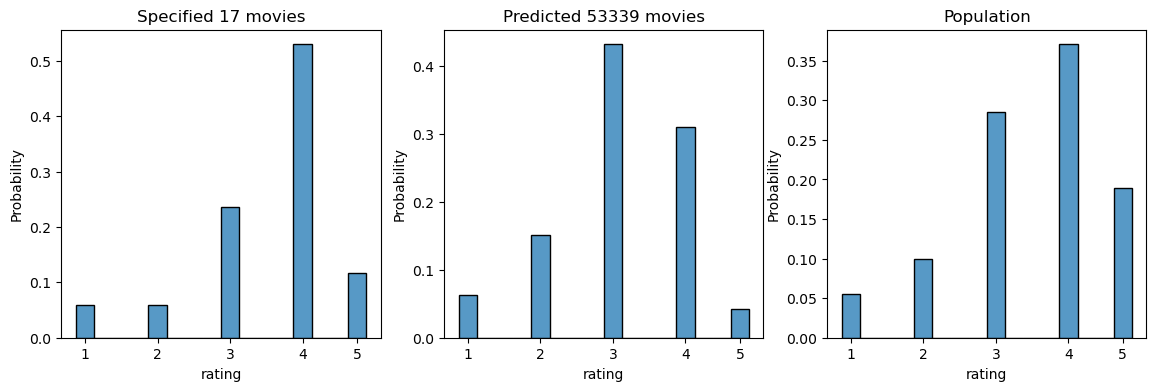

In [198]:
fig, ax = plt.subplots(1,3,figsize=(14,4))
sns.histplot(Rsr[[22],:].data,ax=ax[0],binwidth=.25,stat='probability')
sns.histplot(movie_pred,ax=ax[1],binwidth=.25,stat='probability',)
sns.histplot(df['rating'],ax=ax[2],binwidth=.25,stat='probability')

ax[0].set_title('Specified '+ str(len(Rsr[[22],:].data)) + ' movies')
ax[0].set_xlabel('rating')
ax[0].set_xticks([1.125,2.125,3.125,4.125,4.875])
ax[0].set_xticklabels([1,2,3,4,5])

ax[1].set_title('Predicted '+ str(len(movie_pred)) + ' movies')
ax[1].set_xlabel('rating')
ax[1].set_xticks([1.125,2.125,3.125,4.125,4.875])
ax[1].set_xticklabels([1,2,3,4,5])

ax[2].set_title('Population')
ax[2].set_xlabel('rating')
ax[2].set_xticks([1.125,2.125,3.125,4.125,4.875])
ax[2].set_xticklabels([1,2,3,4,5])

In [217]:
def in1ds2(ar1, ar2, assume_unique=True, invert=False, *, kind='table'):

    if ar2.size == 0:
        return np.zeros_like(ar1, dtype=bool)

    ar2_min = ar2[0]
    ar2_max = ar2[-1]

    print(ar2_min,ar2_max)
    ar2_range = ar2_max - ar2_min
    print(ar2_range)
    outgoing_array = np.zeros_like(ar1, dtype=bool)

    # Make elements 1 where the integer exists in ar2
    isin_helper_ar = np.zeros(ar2_range + 1, dtype=bool)
    print(isin_helper_ar)
    isin_helper_ar[ar2 - ar2_min] = 1
    print(isin_helper_ar)
    # Mask out elements we know won't work
    basic_mask = (ar1 <= ar2_max) & (ar1 >= ar2_min)
    print(basic_mask)
    outgoing_array[basic_mask] = isin_helper_ar[ar1[basic_mask] -
                                                ar2_min]
    print(outgoing_array)
    return outgoing_array


# Old and slower Naive Bayes implementation

In [ ]:
def test_profiler():
    # implement Naive Bayes model with Laplace smoothing

    alpha = 1
    scoring_options = [0.5,1,1.5,2,2.5,3,3.5,4,4.5,5]
    num_scoring_options = len(scoring_options)

    # loop over all users 
    rfin =[]
    for juser in range(0,1):#range(num_users): 
    # loop over all items that user did not rate
        juser_rated = Rsr.indices[Rsr.indptr[juser]:Rsr.indptr[juser+1]] # slower by fact of 50 - Rsr[[1],:].indices # slowest by another factor of 10 - nonzero_cols[nonzero_rows == juser]
        to_rate = np.delete(new_movie_id,juser_rated)
        # slower by a factor of 4 to_rate = np.setdiff1d(new_movie_id, juser_rated, assume_unique=True)# slower by a factor of 10 - list(set(juser_rated) ^ set(range(num_movies)))
        
        for jitem in to_rate[0:1000]:
            # compute probability of rating for all possible ratings       
            rpred = []
            for jprob in scoring_options:    
                # all users that rated item jitem as jprob
                jaa = Rsc.data[Rsc.indptr[jitem]:Rsc.indptr[jitem+1]] == jprob
                a1 = np.count_nonzero(jaa) # a1_old = np.sum(Rsc[:,[jitem]] == jprob) # slower by a factor of ~50
                a2 = nnz_entries_per_col[jitem]
                # all users that rated jitem as jprob
                aa = Rsc.indices[Rsc.indptr[jitem]:Rsc.indptr[jitem+1]][jaa]  # factor of 10 slower -- aa_old = np.argwhere(Rsc[:,[jitem]] == jprob)[:,0]
                prior = (a1 + alpha)/(a2 + num_scoring_options*alpha)     

                
                    
                Pr = 1
                for j in juser_rated: # loop over items that juser rated                            
                    # all users that rated item j
                    bb = Rsc.indices[Rsc.indptr[j]:Rsc.indptr[j+1]] # factor of 100 slower -  bb_old = np.argwhere(Rsc[:,[j]])[:,0]
                    
                    # print(len(aa),len(bb))                  
                    bp = np.isin(bb,aa,assume_unique=True,kind='table')
                    bpr = np.count_nonzero(bp)                  
                    log1 = Rsc.data[Rsc.indptr[j]:Rsc.indptr[j+1]][bp] # factor of 30 slower log1_old = Rsr[aa,[j]]                                         
                    log2 = Rsc.data[Rsc.indptr[j]:Rsc.indptr[j+1]][Rsc.indices[Rsc.indptr[j]:Rsc.indptr[j+1]] == juser] 
                    # factor of 10 slower -- log2_old = Rsc[[juser],[j]]
                    aapr = log1 == log2

                    apr = np.sum(aapr)
                    Pr = Pr * (apr + alpha)/ (bpr + num_scoring_options*alpha)

                rpred.append(prior*Pr)

            # print(jitem)
            
            rfin.append(rpred)


    # np.round(rfin,5)
    # print('finished')

# Some EDA


In [67]:
df_movieId = df_movieId.set_index('movieId')
df = df.set_index('userId')

In [3]:
df2 = df.groupby(by='movieId').agg(mean_ratings=('rating',np.mean),num_ratings=('rating',len)).copy() 

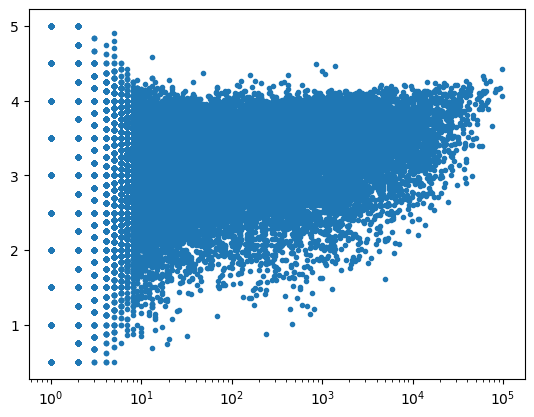

In [6]:
%matplotlib inline
fig, ax = plt.subplots(1,1)
ax.semilogx(df2['num_ratings'],df2['mean_ratings'],'.')



In [76]:
df_movieId[df_movieId['title'] == 'Titanic (1997)']

,title,genres
movieId,,
1721,Titanic (1997),Drama|Romance


In [82]:
df2.sort_values(by='num_ratings',ascending=False).join(other=df_movieId,on='movieId')

,mean_ratings,num_ratings,title,genres
movieId,,,,
318,4.424188,97999.0,"Shawshank Redemption, The (1994)",Crime|Drama
356,4.056585,97040.0,Forrest Gump (1994),Comedy|Drama|Romance|War
296,4.173971,92406.0,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
593,4.151412,87899.0,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
2571,4.149695,84545.0,"Matrix, The (1999)",Action|Sci-Fi|Thriller
...,...,...,...,...
129478,5.000000,1.0,A Blank on the Map (1971),Documentary
129472,3.500000,1.0,The Protagonists (1968),Drama
129470,3.000000,1.0,"Certain, Very Certain, As a Matter of Fact... ...",Comedy


<AxesSubplot:xlabel='rating', ylabel='Count'>

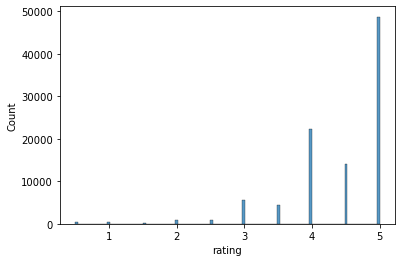

In [83]:
df3 = df.query('movieId == 318').copy()

fig, ax = plt.subplots(1,1)
sns.histplot(df3['rating'],ax=ax)

In [85]:
df_movieId

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy
...,...,...
193876,The Great Glinka (1946),(no genres listed)
193878,Les tribulations d'une caissière (2011),Comedy
193880,Her Name Was Mumu (2016),Drama


In [88]:
# form the ratings matrix and create a model which recommends the top 5-most rated movies
# create ticket time list: ticket times are in intervals of 5 minutes from 9am-11pm (Rome time [CET])
df_col = df_movieId.index
df_row = df.index

data = {df_col[j]:pd.arrays.SparseArray(np.nan,fill_value=np.nan) for j in range(len(df_col))}
df_ratings  = pd.DataFrame(columns=df_col,index=df_row,data=data)






ValueError: Shape of passed values is (1, 58098), indices imply (27753444, 58098)